In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def bgr_to_hsv(b, g, r):
    # Normalize BGR values to [0, 1]
    b, g, r = b/255.0, g/255.0, r/255.0

    # Calculate Value (V)
    cmax = max(r, g, b)
    v = cmax

    # Calculate Saturation (S)
    cmin = min(r, g, b)
    delta = cmax - cmin

    if cmax == 0:
        s = 0
    else:
        s = delta / cmax

    # Calculate Hue (H)
    if delta == 0:
        h = 0
    elif cmax == r:
        h = 60 * (((g - b) / delta) % 6)
    elif cmax == g:
        h = 60 * (((b - r) / delta) + 2)
    else:  # cmax == b
        h = 60 * (((r - g) / delta) + 4)

    # Scale to OpenCV ranges (H: 0-180, S&V: 0-255)
    h = h / 2  # [0, 360] -> [0, 180]
    s = s * 255
    v = v * 255

    return int(h), int(s), int(v)

In [3]:
def create_skin_histogram(images, bins=16):
    # Initialize histograms for H and S channels
    h_hist = np.zeros(bins)
    s_hist = np.zeros(bins)
    total_skin_pixels = 0

    # Predefined skin color range in HSV for initial segmentation
    lower_hsv = [0, 40, 30]
    upper_hsv = [25, 255, 255]

    # Process all training images
    for image in images:
        height, width, _ = image.shape

        # Count skin pixels based on color thresholds
        for y in range(height):
            for x in range(width):
                b, g, r = image[y, x]
                h, s, v = bgr_to_hsv(b, g, r)

                # Check if pixel is within skin color range
                if (lower_hsv[0] <= h <= upper_hsv[0] and
                    lower_hsv[1] <= s <= upper_hsv[1] and
                    lower_hsv[2] <= v <= upper_hsv[2]):

                    # Add to histogram
                    h_bin = min(int(h * bins / 180), bins-1)
                    s_bin = min(int(s * bins / 256), bins-1)
                    h_hist[h_bin] += 1
                    s_hist[s_bin] += 1
                    total_skin_pixels += 1

    # Normalize histograms
    if total_skin_pixels > 0:
        h_hist = h_hist / total_skin_pixels
        s_hist = s_hist / total_skin_pixels

    return h_hist, s_hist

In [4]:
def calculate_backprojection(image, h_hist, s_hist, bins=16):
    height, width, _ = image.shape
    backproj = np.zeros((height, width), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            b, g, r = image[y, x]
            h, s, v = bgr_to_hsv(b, g, r)

            h_bin = min(int(h * bins / 180), bins-1)
            s_bin = min(int(s * bins / 256), bins-1)

            # Calculate probability this pixel is skin
            backproj[y, x] = h_hist[h_bin] * s_hist[s_bin]

    # Normalize to 0-255 range
    if np.max(backproj) > 0:
        backproj = backproj * 255.0 / np.max(backproj)

    return backproj.astype(np.uint8)

In [5]:
def apply_morphology(mask, kernel_size=5):
    height, width = mask.shape

    # Create circular kernel
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.uint8)
    center = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            if ((i - center)**2 + (j - center)**2) <= center**2:
                kernel[i, j] = 1

    # Dilation (expand)
    dilated = np.zeros_like(mask)
    for y in range(height):
        for x in range(width):
            max_val = 0
            for ky in range(kernel_size):
                for kx in range(kernel_size):
                    i, j = y - center + ky, x - center + kx
                    if 0 <= i < height and 0 <= j < width and kernel[ky, kx] == 1:
                        max_val = max(max_val, mask[i, j])
            dilated[y, x] = max_val

    # Erosion (shrink)
    eroded = np.zeros_like(dilated)
    for y in range(height):
        for x in range(width):
            min_val = 255
            for ky in range(kernel_size):
                for kx in range(kernel_size):
                    i, j = y - center + ky, x - center + kx
                    if 0 <= i < height and 0 <= j < width and kernel[ky, kx] == 1:
                        min_val = min(min_val, dilated[i, j])
            eroded[y, x] = min_val

    return eroded

In [12]:
def segment_skin(train_image_paths, test_image_path, threshold=30):
    # Load training images
    train_images = []
    for path in train_image_paths:
        img = cv2.imread(path)
        if img is not None:
            train_images.append(img)
        else:
            print(f"Error: Could not read training image at {path}")

    if len(train_images) == 0:
        print("Error: No valid training images found")
        return

    # Create skin histogram from training data
    h_hist, s_hist = create_skin_histogram(train_images)

    # Load test image
    test_img = cv2.imread(test_image_path)
    if test_img is None:
        print(f"Error: Could not read test image at {test_image_path}")
        return
    backproj = calculate_backprojection(test_img, h_hist, s_hist)

    # Threshold the backprojection to create binary mask
    skin_mask = np.zeros_like(backproj)
    for y in range(backproj.shape[0]):
        for x in range(backproj.shape[1]):
            if backproj[y, x] > threshold:
                skin_mask[y, x] = 255

    # Clean up the mask with morphological operations
    skin_mask = apply_morphology(skin_mask)

    # Apply mask to original image
    result_img = np.copy(test_img)
    for y in range(test_img.shape[0]):
        for x in range(test_img.shape[1]):
            if skin_mask[y, x] == 0:
                result_img[y, x] = [255, 255, 255]  # Set non-skin pixels to white


    plt.subplot(1, 3, 1)
    plt.title("Test Image")
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')

    plt.subplot(1, 3,2)
    plt.title("Segmented Skin")
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

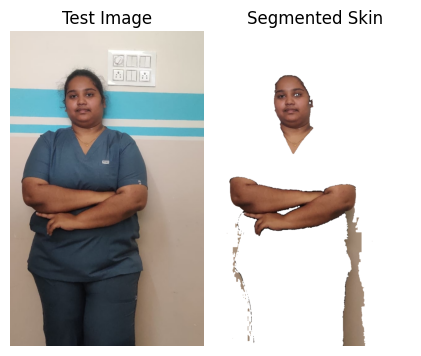

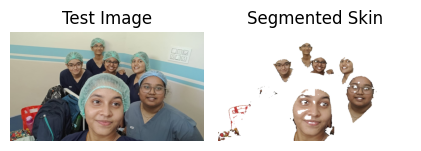

In [22]:
train_image_paths=["train1.jpg","train2.jpg","train3.jpg"]
test_image_paths=["test1.jpg","test2.jpg"]
for i in test_image_paths:
  segment_skin(train_image_paths,i)